<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Assign_wcs()
<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /tmp/crds_cache


<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* logging
* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot a shape
* pysiaf for SIAF access
* miricoord for coordinate conversion tools
* gwcs for wcs tools

[Top of Page](#title_ID)

In [3]:
import inspect
import numpy as np
import glob
import os
import logging
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy.table import Table, Column
from astropy.utils.data import download_file
from gwcs.wcstools import grid_from_bounding_box
from numpy.testing import assert_allclose

from pysiaf import Siaf
import miricoord.imager.mirim_tools as mt
import miricoord.lrs.toolversions.lrs_pipetools_cdp7 as tv
from miricoord.lrs.lrs_pipetools import xytov2v3lam

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline


<a id="intro_ID"></a>
# Introduction


In this notebook we will test the assign_wcs step of Spec2Pipeline() for **LRS slit** observations.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [4]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

In [5]:
print(files)

['/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif/miri_lrs_slit_pt_nod1_v2.3.fits', '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif/miri_lrs_slit_pt_nod2_v2.3.fits']


<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the assign_wcs() step, which is part of the Spec2Pipeline. 

[Top of Page](#title_ID)

### CalDetector1

We first run the data through the Detector1 pipeline, ensuring to pass the calwebb_detector1.cfg configuration file. 

In [6]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True)
    if 'nod1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2022-09-19 15:26:58,890 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf    1.1 K bytes  (1 / 1 files) (0 / 1.1 K bytes)


2022-09-19 15:26:58,938 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /tmp/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf


2022-09-19 15:26:58,968 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-09-19 15:26:58,971 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-09-19 15:26:58,973 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-09-19 15:26:58,975 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-09-19 15:26:58,977 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-09-19 15:26:58,978 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-09-19 15:26:58,980 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-09-19 15:26:58,981 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-09-19 15:26:58,982 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-09-19 15:26:58,983 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-09-19 15:26:58,985 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-09-19 15:26:58,986 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-09-19 15:26:58,987 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-09-19 15:26:58,988 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-09-19 15:26:58,990 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-09-19 15:26:58,991 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-09-19 15:26:58,992 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-09-19 15:26:59,209 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif/miri_lrs_slit_pt_nod1_v2.3.fits',).


2022-09-19 15:26:59,219 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-09-19 15:26:59,423 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-09-19 15:26:59,428 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits    3.4 G bytes  (1 / 8 files) (0 / 3.7 G bytes)


2022-09-19 15:27:32,153 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits    4.2 M bytes  (2 / 8 files) (3.4 G / 3.7 G bytes)


2022-09-19 15:27:32,251 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits   46.5 M bytes  (3 / 8 files) (3.4 G / 3.7 G bytes)


2022-09-19 15:27:32,523 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits    4.3 M bytes  (4 / 8 files) (3.4 G / 3.7 G bytes)


2022-09-19 15:27:32,572 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits    4.2 M bytes  (5 / 8 files) (3.4 G / 3.7 G bytes)


2022-09-19 15:27:32,668 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits  255.8 M bytes  (6 / 8 files) (3.5 G / 3.7 G bytes)


2022-09-19 15:27:37,890 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits   37.4 K bytes  (7 / 8 files) (3.7 G / 3.7 G bytes)


2022-09-19 15:27:37,946 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits    9.5 M bytes  (8 / 8 files) (3.7 G / 3.7 G bytes)


2022-09-19 15:27:38,809 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2022-09-19 15:27:38,811 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2022-09-19 15:27:38,811 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2022-09-19 15:27:38,812 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits'.


2022-09-19 15:27:38,813 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-09-19 15:27:38,813 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2022-09-19 15:27:38,814 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-09-19 15:27:38,814 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.


2022-09-19 15:27:38,815 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits'.


2022-09-19 15:27:38,815 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2022-09-19 15:27:38,816 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-09-19 15:27:38,816 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-09-19 15:27:38,817 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-09-19 15:27:38,818 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-09-19 15:27:39,195 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:39,197 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:27:39,326 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-09-19 15:27:39,328 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-09-19 15:27:39,332 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-09-19 15:27:39,473 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:39,474 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:27:39,496 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits


2022-09-19 15:27:39,786 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-09-19 15:27:39,972 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:39,974 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'n_pix_grow_sat': 1}


2022-09-19 15:27:39,996 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2022-09-19 15:27:40,848 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-09-19 15:27:40,860 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-09-19 15:27:40,869 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-09-19 15:27:41,076 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:41,077 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:27:41,078 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-09-19 15:27:41,082 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-09-19 15:27:41,215 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:41,216 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:27:41,379 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-09-19 15:27:41,511 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:41,513 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:27:41,648 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-09-19 15:27:41,781 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:41,783 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:27:41,805 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits


2022-09-19 15:27:42,157 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-09-19 15:27:42,288 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:42,290 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:27:42,313 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2022-09-19 15:27:42,802 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-09-19 15:27:42,931 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:42,932 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'type': 'baseline'}


2022-09-19 15:27:42,955 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits


2022-09-19 15:27:43,115 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-09-19 15:27:43,233 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:43,235 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'dark_output': None}


2022-09-19 15:27:43,258 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2022-09-19 15:27:44,784 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-09-19 15:27:44,787 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-09-19 15:27:45,664 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-09-19 15:27:45,907 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:45,909 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-09-19 15:27:46,026 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-09-19 15:27:46,027 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-09-19 15:27:46,027 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-09-19 15:27:46,028 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-09-19 15:27:46,028 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-09-19 15:27:46,029 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-09-19 15:27:46,029 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-09-19 15:27:46,030 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-09-19 15:27:46,034 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-09-19 15:27:46,324 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-09-19 15:27:46,388 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-09-19 15:27:46,605 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:46,607 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-09-19 15:27:46,618 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-09-19 15:27:46,631 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:27:46,668 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:27:46,909 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-09-19 15:27:46,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-09-19 15:27:47,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28384 pixels with at least one CR from five or more groups.


2022-09-19 15:27:47,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:27:47,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:27:51,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-09-19 15:27:52,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12669 pixels with at least one CR from five or more groups.


2022-09-19 15:27:52,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:27:52,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:27:54,341 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.43074 sec


2022-09-19 15:27:54,347 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.728934


2022-09-19 15:27:54,354 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-09-19 15:27:54,548 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:27:54,550 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-09-19 15:27:54,589 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:27:54,589 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:27:54,647 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-09-19 15:27:54,648 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-09-19 15:27:54,751 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-09-19 15:27:54,753 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-09-19 15:28:06,613 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-09-19 15:28:06,617 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-09-19 15:28:06,726 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-09-19 15:28:06,888 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:28:06,889 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:06,929 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:28:06,929 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:28:06,934 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:28:07,053 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-09-19 15:28:07,055 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:07,098 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:28:07,099 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:28:07,104 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:28:07,198 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2022-09-19 15:28:07,199 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-09-19 15:28:07,199 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:28:07,265 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-09-19 15:28:07,266 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-09-19 15:28:07,473 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /tmp/crds_cache/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf


2022-09-19 15:28:07,491 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-09-19 15:28:07,493 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-09-19 15:28:07,494 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-09-19 15:28:07,496 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-09-19 15:28:07,497 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-09-19 15:28:07,498 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-09-19 15:28:07,499 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-09-19 15:28:07,500 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-09-19 15:28:07,501 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-09-19 15:28:07,503 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-09-19 15:28:07,504 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-09-19 15:28:07,505 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-09-19 15:28:07,506 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-09-19 15:28:07,507 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-09-19 15:28:07,509 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-09-19 15:28:07,510 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-09-19 15:28:07,511 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-09-19 15:28:07,634 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif/miri_lrs_slit_pt_nod2_v2.3.fits',).


2022-09-19 15:28:07,645 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-09-19 15:28:07,823 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-09-19 15:28:07,828 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2022-09-19 15:28:07,829 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2022-09-19 15:28:07,829 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2022-09-19 15:28:07,830 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits'.


2022-09-19 15:28:07,830 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-09-19 15:28:07,831 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2022-09-19 15:28:07,831 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-09-19 15:28:07,832 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.


2022-09-19 15:28:07,832 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits'.


2022-09-19 15:28:07,833 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2022-09-19 15:28:07,833 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-09-19 15:28:07,834 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-09-19 15:28:07,834 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-09-19 15:28:07,835 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-09-19 15:28:08,141 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:08,143 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:08,253 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-09-19 15:28:08,254 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-09-19 15:28:08,256 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-09-19 15:28:08,376 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:08,378 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:08,400 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_mask_0028.fits


2022-09-19 15:28:08,679 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-09-19 15:28:08,798 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:08,799 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'n_pix_grow_sat': 1}


2022-09-19 15:28:08,821 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2022-09-19 15:28:09,744 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-09-19 15:28:09,757 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-09-19 15:28:09,766 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-09-19 15:28:09,884 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:09,885 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:09,885 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-09-19 15:28:09,888 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-09-19 15:28:10,005 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:10,007 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:10,130 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-09-19 15:28:10,248 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:10,250 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:10,358 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-09-19 15:28:10,475 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:10,477 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:10,500 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits


2022-09-19 15:28:10,864 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-09-19 15:28:10,982 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:10,984 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:11,007 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2022-09-19 15:28:11,435 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-09-19 15:28:11,552 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:11,554 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'type': 'baseline'}


2022-09-19 15:28:11,576 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_rscd_0014.fits


2022-09-19 15:28:11,733 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-09-19 15:28:11,850 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:11,852 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'dark_output': None}


2022-09-19 15:28:11,874 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2022-09-19 15:28:13,576 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-09-19 15:28:13,577 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-09-19 15:28:14,349 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-09-19 15:28:14,502 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:14,503 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-09-19 15:28:14,624 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-09-19 15:28:14,625 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-09-19 15:28:14,626 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-09-19 15:28:14,626 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-09-19 15:28:14,627 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-09-19 15:28:14,627 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-09-19 15:28:14,627 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-09-19 15:28:14,628 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-09-19 15:28:14,631 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-09-19 15:28:14,901 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-09-19 15:28:14,956 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-09-19 15:28:15,076 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:15,078 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-09-19 15:28:15,088 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-09-19 15:28:15,100 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:28:15,140 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:28:15,335 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-09-19 15:28:15,377 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-09-19 15:28:16,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28153 pixels with at least one CR from five or more groups.


2022-09-19 15:28:16,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:28:16,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:28:20,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-09-19 15:28:21,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12958 pixels with at least one CR from five or more groups.


2022-09-19 15:28:21,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-09-19 15:28:21,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-09-19 15:28:22,733 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.3973 sec


2022-09-19 15:28:22,737 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.649188


2022-09-19 15:28:22,743 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-09-19 15:28:22,872 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:22,874 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-09-19 15:28:22,907 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2022-09-19 15:28:22,908 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /tmp/crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2022-09-19 15:28:22,960 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-09-19 15:28:22,961 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-09-19 15:28:23,050 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-09-19 15:28:23,051 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-09-19 15:28:34,980 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-09-19 15:28:34,982 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-09-19 15:28:35,073 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-09-19 15:28:35,216 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:35,217 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:35,256 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:28:35,257 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:28:35,262 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:28:35,385 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-09-19 15:28:35,386 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpmtvt3rif'}


2022-09-19 15:28:35,433 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-09-19 15:28:35,434 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-09-19 15:28:35,439 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-09-19 15:28:35,543 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2022-09-19 15:28:35,543 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-09-19 15:28:35,544 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:28:35,613 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-09-19 15:28:35,614 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


### AssignWcs

The AssignWcs step should not change anything in the science data or error extension. It attaches the WCS information to the data, so that a location in detector pixels can be reconstructed to an RA, dec, wavelength in spatial and spectral space. 

In [7]:
awcs_out = []

for dd in det1_out:
    awcs = AssignWcsStep.call(dd,save_results=True) 
    awcs_out.append(awcs)

2022-09-19 15:28:35,633 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-09-19 15:28:35,755 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-09-19 15:28:35,756 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-09-19 15:28:35,773 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf    9.9 K bytes  (1 / 1 files) (0 / 9.9 K bytes)


2022-09-19 15:28:35,814 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits   46.1 K bytes  (1 / 1 files) (0 / 46.1 K bytes)


2022-09-19 15:28:36,091 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/tmp/crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/tmp/crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-09-19 15:28:36,186 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-09-19 15:28:36,186 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-09-19 15:28:36,187 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-09-19 15:28:36,201 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:28:36,375 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2022-09-19 15:28:36,376 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-09-19 15:28:36,385 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-09-19 15:28:36,503 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-09-19 15:28:36,505 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-09-19 15:28:36,765 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/tmp/crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/tmp/crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-09-19 15:28:36,855 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-09-19 15:28:36,856 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-09-19 15:28:36,856 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-09-19 15:28:36,870 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0977.pmap


2022-09-19 15:28:37,045 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2022-09-19 15:28:37,045 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


<a id="residual_ID"></a>
## Output checks and tests

We can use the output model to run the following checks:

* the SCI extension is unchanged from the step input (accept default tolerances for the np.allclose() function)
* we visualize the location of the bounding box.
* we use the wcs information assigned in the step to check the RA, dec, wavelength assignment at some reference locations. 

For LRS slit, the bounding box is defined from the wave/distortion reference file, as follows:

``bb_sub = ((np.floor(x0.min() + zero_point[0]) - 0.5, np.ceil(x1.max() + zero_point[0]) + 0.5),
                  (np.floor(y2.min() + zero_point[1]) - 0.5, np.ceil(y0.max() + zero_point[1]) + 0.5))``

where ``x0`` is the x-coordinate of the top-left corner, ``x1`` of the top-right corner, ``y0`` the y-coordinate of the top-left corner, ``y2`` of the bottom-right corner. ``zero_point`` is the slit centre coordiate as defined in the IMX and IMY header keywords. The 0.5 is to account for different pixel counting conventions.

[Top of Page](#title_ID)

In [8]:
# Do a numeric check between input and output
for (aa, dd, nn) in zip(awcs_out, det1_out, nodno):
    try:
        assert np.allclose(aa.data, dd.data, equal_nan=True)
    except:
        print("Step input and output don't match for {}".format(nodno))
    #assert np.allclose(aa.data, dd.data, equal_nan=True), "Step input and output don't match for {}".format(nodno)

In [9]:
for aa, nn in zip(awcs_out, nods):

    bbox_w = aa.meta.wcs.bounding_box[0][1] - aa.meta.wcs.bounding_box[0][0]
    bbox_ht = aa.meta.wcs.bounding_box[1][1] - aa.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1})= {0} '.format(aa.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))
    
# Check that the bounding boxes are the same for both nods:
try:
    assert awcs_out[0].meta.wcs.bounding_box == awcs_out[1].meta.wcs.bounding_box
except:
    print("Bounding box for nod positions don't match")

#assert awcs_out[0].meta.wcs.bounding_box == awcs_out[1].meta.wcs.bounding_box, "Bounding box for nod positions don't match"

Model bbox (nod1)= ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=6.5, upper=396.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
) 
Model: Height x width of bounding box (nod1)= 390.0 x 44.0 pixels
Model bbox (nod2)= ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=6.5, upper=396.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
) 
Model: Height x width of bounding box (nod2)= 390.0 x 44.0 pixels


(1024, 1032)

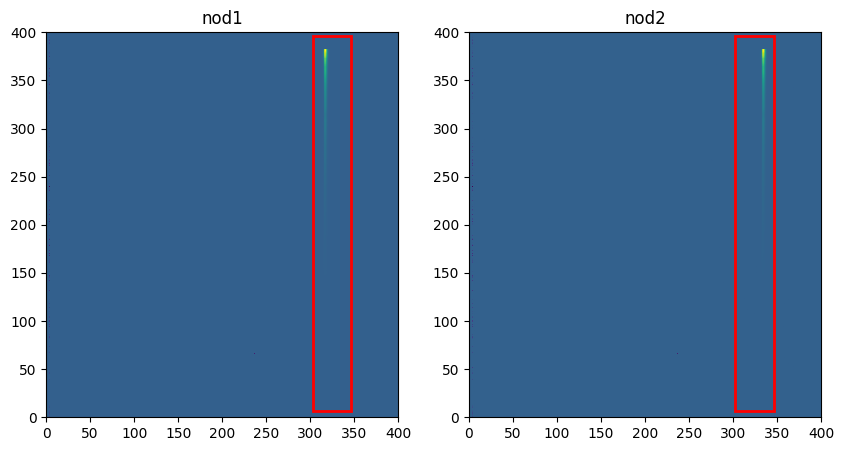

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

bbox0 = Rectangle((awcs_out[0].meta.wcs.bounding_box[0][0],awcs_out[0].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')
bbox1 = Rectangle((awcs_out[1].meta.wcs.bounding_box[0][0],awcs_out[1].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

ax[0].imshow(awcs_out[0].data, origin='lower', interpolation='None', aspect='auto')
ax[0].add_patch(bbox0)
ax[0].set_xlim([0,400])
ax[0].set_ylim([0,400])
ax[0].set_title(nods[0])

ax[1].imshow(awcs_out[1].data, origin='lower', interpolation='None', aspect='auto')
ax[1].add_patch(bbox1)
ax[1].set_xlim([0,400])
ax[1].set_ylim([0,400])
ax[1].set_title(nods[1])

np.shape(awcs_out[0].data)

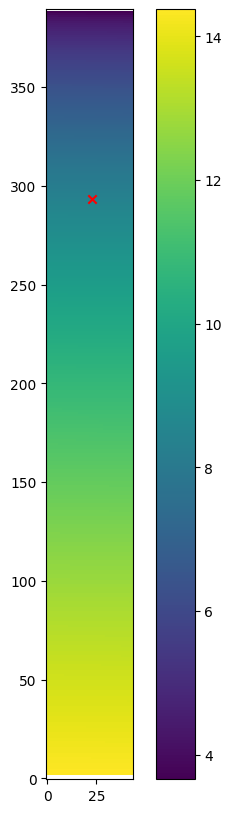

In [11]:
# Plot the wavelength solution based on the wcs information in the model
siaf = Siaf('MIRI')
ap = siaf['MIRIM_SLIT']
refpx_tel = ap.reference_point(to_frame='tel')
refpx_abs = mt.v2v3toxy(refpx_tel[0], refpx_tel[1], filter='F770W')
refpx = (refpx_abs[0] - awcs_out[0].meta.wcs.bounding_box[0][0], refpx_abs[1] - awcs_out[0].meta.wcs.bounding_box[1][0])
#print(refpx)

x,y = grid_from_bounding_box(awcs_out[0].meta.wcs.bounding_box)
ra, dec, lam = awcs_out[0].meta.wcs(x, y)

fig = plt.figure(figsize=[6,10])
imlam=plt.imshow(lam, origin='lower', interpolation='None')
cbar = fig.colorbar(imlam)
plt.scatter(refpx[0], refpx[1], marker='x', color='r')

Load the set of test coordinates from ``miricoord``. Then calculate the wavelength of these coordinates from the assign_wcs output models, and verify that they are close. If all the ``assert`` tests pass, this test is successful and complete.

In [12]:
xt,yt,v2t,v3t,lamt,stype=tv.testdata()

lamtest1 = np.zeros(3)
lamtest2 = np.zeros(3)
v2test1 = np.zeros(3)
v3test1 = np.zeros(3)
lt1 = np.zeros(3)

print('**** TEST SET ****')
print(' x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test')
for i in range (3):
    v2test1[i], v3test1[i], lt1[i] = xytov2v3lam(xt[0][i], yt[0][i], 'slit') 
    ra, dec, lamtest1[i] = awcs_out[0].meta.wcs(xt[0][i], yt[0][i])
    ra, dec, lamtest2[i] = awcs_out[1].meta.wcs(xt[0][i], yt[0][i])
    print('{0}  {1}   {2}    {3:.5f}    {4:.5f}  {5:.5f}   {6:.5f}   {7:.5f}   {8:.5f}'.format(xt[0][i], yt[0][i], lamt[0][i], lamtest1[i], lamtest2[i], v2t[0][i], v3t[0][i], v2test1[i], v3test1[i]))
    
    try:
        assert_allclose(lamt[0][i], lamtest1[i], atol=0.05)
    except:
        print("AssertError: assert1 failed")
        
    try:    
        assert_allclose(lamt[0][i], lamtest2[i], atol=0.05)
    except:
        print("AssertError: assert2 failed")
        
    try:    
        assert_allclose(v2t[0][i], v2test1[i], atol=0.05)
    except:
        print("AssertError: assert3 failed")

    try:    
        assert_allclose(v3t[0][i], v3test1[i], atol=0.05)
    except:
        print("AssertError: assert4 failed")
        

**** TEST SET ****
 x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test
325.13  299.7   8.41039    8.41039    8.41039  -415.06900   -400.57590   -414.87799   -400.56818
AssertError: assert3 failed


325.13  29.7   14.05363    14.05363    14.05363  -415.19460   -400.56550   -415.09492   -400.55032
AssertError: assert3 failed
345.13  379.7   5.1474    5.14743    5.14743  -417.23700   -400.39580   -417.01788   -400.39214
AssertError: assert3 failed


<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA MIRI Instrument & Calibration Scientist, MIRI branch
<br>**Updated On:** 12/08/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 